In [56]:
import pandas as pd
import os
import hvplot.pandas
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from dotenv import load_dotenv
from pathlib import Path
import numpy as np

In [57]:
load_dotenv()

True

In [58]:
alpaca_api_key = os.getenv('ALPACA_API_KEY')
alpaca_secret_key = os.getenv('ALPACA_SECRET_KEY')

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version='v2')

In [59]:
tickers = ['BTCUSD', 'ETHUSD']

start_date = pd.Timestamp('2016-01-04', tz="America/New_York").isoformat()
end_date = pd.Timestamp('2022-05-30', tz="America/New_York").isoformat()

timeframe = "1Day"

In [60]:
crypto_df = alpaca.get_crypto_bars(
    tickers,
    timeframe,
    '2016-01-04',
    '2022-05-30',
    limit = 10000,
    exchanges = 'CBSE' 
    ).df

In [61]:
SPY = alpaca.get_bars(
    'SPY',
    timeframe,
    start = start_date,
    end = end_date,
    limit = 10000
).df

In [62]:
# Removing exchange column from crypto_af
crypto_df = crypto_df.drop(columns='exchange')

In [63]:
# Seperating BTC & ETH in to seperate dataframes
BTC = crypto_df[crypto_df['symbol']=='BTCUSD'].drop('symbol', axis=1)
ETH = crypto_df[crypto_df['symbol']=='ETHUSD'].drop('symbol', axis=1)

In [64]:
# Converting timestamp to pandas datetime & removing time(hours/seconds)
SPY.index = pd.to_datetime(SPY.index)
SPY.index = SPY.index.date
ETH.index = pd.to_datetime(ETH.index)
ETH.index = ETH.index.date
BTC.index = pd.to_datetime(BTC.index)
BTC.index = BTC.index.date

In [65]:
prices_df = pd.concat([SPY, BTC, ETH], axis=1, keys=['SPY', 'BTC', 'ETH']).dropna()
prices_df

SPY                                                      \
              open      high      low   close       volume trade_count   
2016-05-17  206.44  206.8000  204.230  204.82  114872440.0    415424.0   
2016-05-18  204.44  206.3000  203.630  204.91  123493379.0    500613.0   
2016-05-19  204.00  204.5400  202.780  204.24  115274287.0    442744.0   
2016-05-20  204.95  206.1000  204.860  205.49  102240408.0    332714.0   
2016-05-23  205.48  205.8400  204.985  205.16   58682576.0    233560.0   
...            ...       ...      ...     ...          ...         ...   
2022-05-23  392.83  397.7300  390.380  397.05   75050164.0    712247.0   
2022-05-24  392.52  395.1500  386.960  393.89   90896060.0    799660.0   
2022-05-25  392.36  399.4500  391.890  397.37   91073759.0    763631.0   
2022-05-26  398.68  407.0400  398.450  405.31   81957864.0    604995.0   
2022-05-27  407.97  415.3801  407.700  415.26   84364212.0    600600.0   

                             BTC                      ...                \
                  vwap      open      high       low  ...        volume   
2016-05-17  205.444427    454.19    456.50    453.60  ...   1226.471174   
2016-05-18  204.890596    455.56    456.41    455.23  ...   1009.636459   
2016-05-19  203.750060    437.91    443.46    435.50  ...   2304.734684   
2016-05-20  205.417234    440.45    445.85    440.00  ...   4874.000678   
2016-05-23  205.403720    445.56    448.50    445.01  ...   1272.319422   
...                ...       ...       ...       ...  ...           ...   
2022-05-23  395.152874  30095.11  30635.39  28847.72  ...  23772.472550   
2022-05-24  391.544331  29324.32  30192.08  28611.00  ...  18455.621494   
2022-05-25  395.782204  30068.07  30102.90  29296.12  ...  16969.747700   
2022-05-26  404.260074  29733.94  29820.45  28000.00  ...  26982.273905   
2022-05-27  412.482169  28887.65  29351.89  28220.00  ...  18561.901937   

                                          ETH                             \
           trade_count          vwap     open     high      low    close   
2016-05-17        4793    455.218844    12.50    14.93    12.50    14.00   
2016-05-18        7034    455.961531    13.60    13.60    13.03    13.18   
2016-05-19        6711    440.175993    14.82    14.82    14.82    14.82   
2016-05-20       25536    443.714022    13.72    14.17    13.71    14.17   
2016-05-23        9511    446.680037    13.68    13.74    13.68    13.74   
...                ...           ...      ...      ...      ...      ...   
2022-05-23      612281  29883.265887  2025.60  2087.60  1954.40  1985.73   
2022-05-24      546282  29354.834532  1985.63  2020.00  1909.51  2003.68   
2022-05-25      501455  29705.958237  2003.96  2009.71  1930.79  1936.05   
2022-05-26      690906  29124.069400  1935.96  1943.92  1726.47  1743.00   
2022-05-27      595210  28788.040865  1742.99  1820.84  1702.53  1720.72   

                                                    
                   volume trade_count         vwap  
2016-05-17      23.517331        15.0    13.627887  
2016-05-18     459.004496        65.0    13.101801  
2016-05-19      16.000000         2.0    14.820000  
2016-05-20     238.166617        17.0    13.776081  
2016-05-23       1.000000         3.0    13.720367  
...                   ...         ...          ...  
2022-05-23  192770.352106    530608.0  2029.977475  
2022-05-24  172454.328869    467039.0  1962.109432  
2022-05-25  155937.896097    472423.0  1961.552165  
2022-05-26  343759.845322    874801.0  1818.540685  
2022-05-27  284193.675644    828986.0  1755.086013  

[1520 rows x 21 columns]

In [66]:
closing_prices_df = pd.DataFrame()
assets = ['SPY', 'BTC', 'ETH']
for asset in assets:
    closing_prices_df[asset] = prices_df[asset]["close"]
display(closing_prices_df.head())
display(closing_prices_df.tail())

,SPY,BTC,ETH
2016-05-17,204.82,456.21,14.00
2016-05-18,204.91,456.20,13.18
2016-05-19,204.24,440.72,14.82
2016-05-20,205.49,445.65,14.17
2016-05-23,205.16,447.42,13.74


,SPY,BTC,ETH
2022-05-23,397.05,29322.98,1985.73
2022-05-24,393.89,30069.27,2003.68
2022-05-25,397.37,29733.94,1936.05
2022-05-26,405.31,28890.69,1743.00
2022-05-27,415.26,28576.21,1720.72


In [67]:
#Daily Returns
dailyReturns_df=closing_prices_df.pct_change().dropna()

In [68]:
dailyReturns_df.head()

,SPY,BTC,ETH
2016-05-18,0.000439,-0.000022,-0.058571
2016-05-19,-0.003270,-0.033932,0.124431
2016-05-20,0.006120,0.011186,-0.043860
2016-05-23,-0.001606,0.003972,-0.030346
2016-05-24,0.013209,-0.000961,-0.058224


<AxesSubplot:title={'center':'Daily Returns'}>

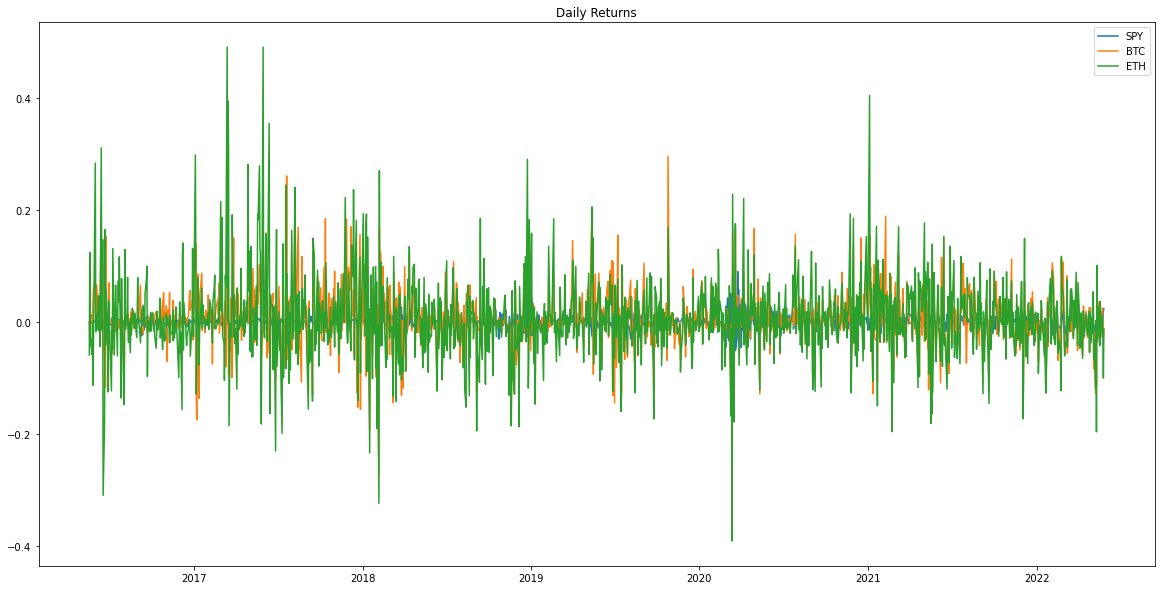

In [69]:
dailyReturns_df.plot(figsize=(20, 10), title="Daily Returns")

In [70]:
all_cumulative_returns_df = (1 + dailyReturns_df).cumprod()
all_cumulative_returns_df.tail()

,SPY,BTC,ETH
2022-05-23,1.938531,64.275180,141.837857
2022-05-24,1.923103,65.911028,143.120000
2022-05-25,1.940094,65.175994,138.289286
2022-05-26,1.978859,63.327612,124.500000
2022-05-27,2.027439,62.638281,122.908571


<AxesSubplot:title={'center':'Cumulative Returns'}>

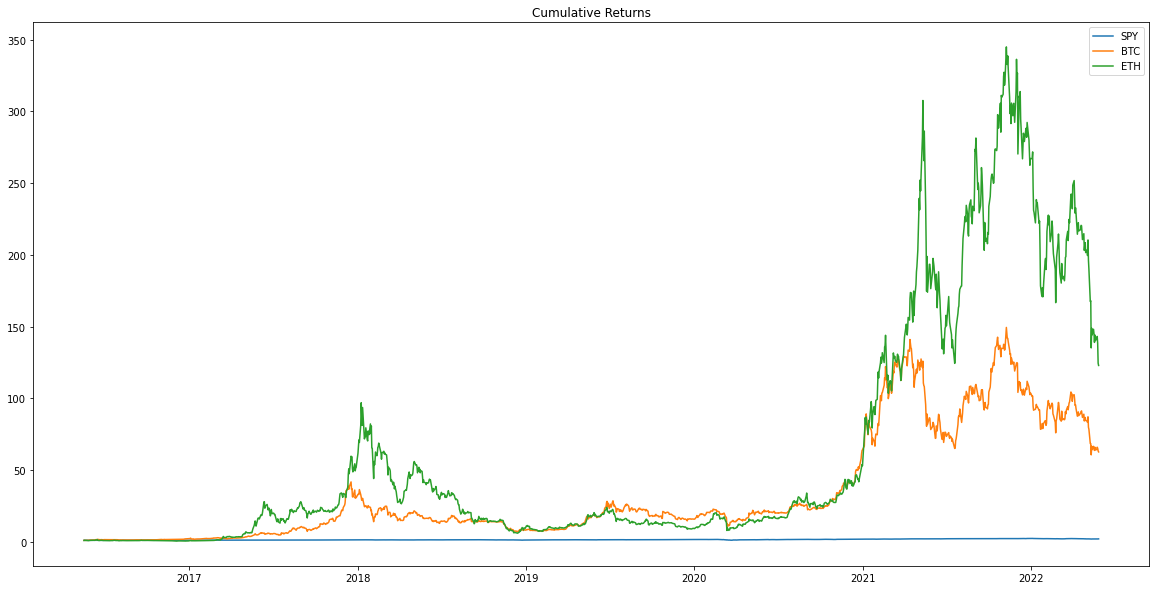

In [71]:
all_cumulative_returns_df.plot(figsize=(20,10), title="Cumulative Returns")

<AxesSubplot:title={'center':'SPY, BTC, ETC Volatility'}>

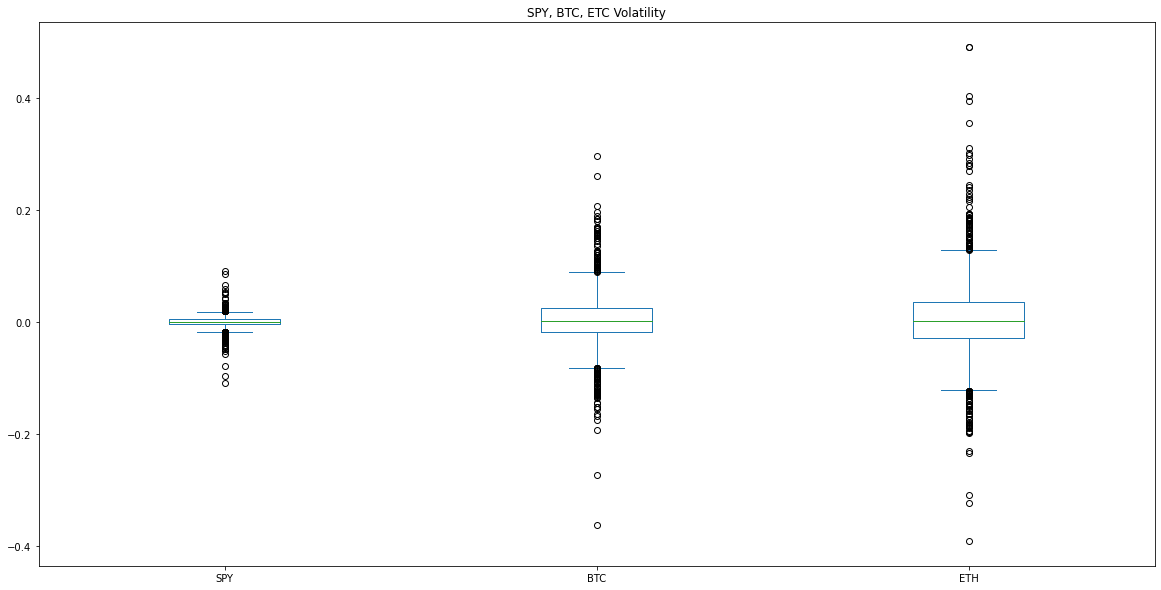

In [72]:
dailyReturns_df.plot.box(figsize=(20,10), title="SPY, BTC, ETC Volatility")

In [74]:
#Based on Volatility, ETH has the most volatility

<AxesSubplot:title={'center':'21 Day Rolling Standard Deviation'}>

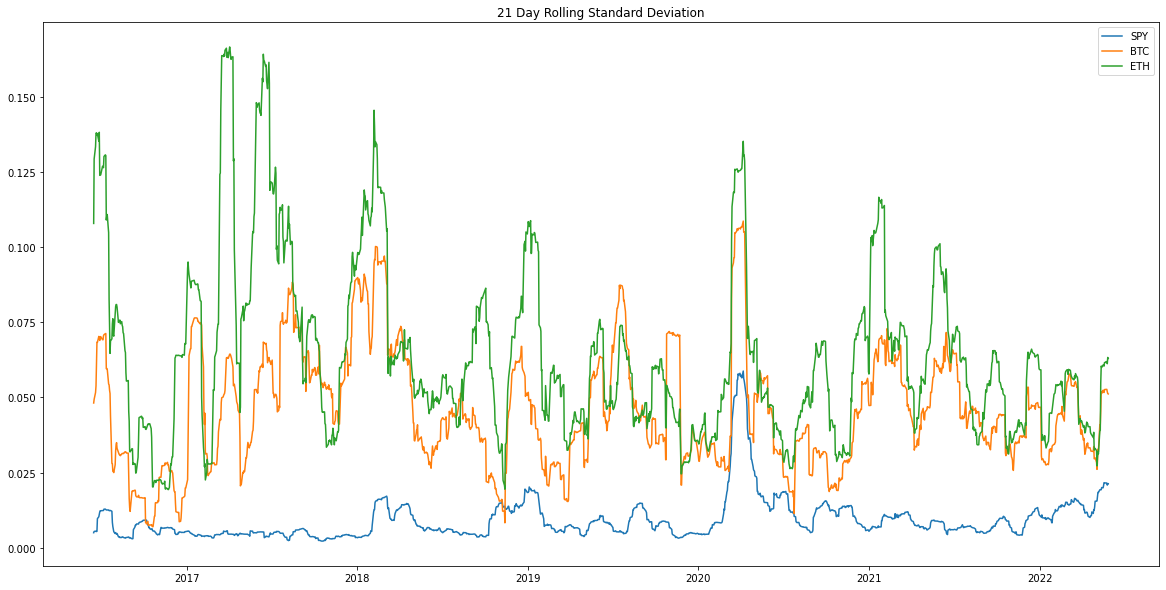

In [75]:
### Rolling window
dailyReturns_df.rolling(window=21).std().plot(figsize=(20,10), title="21 Day Rolling Standard Deviation")

In [76]:
# Calculate the annual average return data for the for SPY,BTC,ETC 
all_annual_average_returns = dailyReturns_df.mean() * 252
all_annual_average_returns.sort_values()

SPY    0.134876
BTC    1.002972
ETH    1.420953
dtype: float64

In [77]:


all_standard_deviations = dailyReturns_df.std()
all_standard_deviations.sort_values()

all_annual_standard_deviations = all_standard_deviations * np.sqrt(252)
all_annual_standard_deviations.sort_values()

SPY    0.187040
BTC    0.792054
ETH    1.129572
dtype: float64

In [78]:
#Sharpe Ratio
all_sharpe_ratios = all_annual_average_returns / all_annual_standard_deviations
all_sharpe_ratios.sort_values()


SPY    0.721109
ETH    1.257957
BTC    1.266291
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios'}>

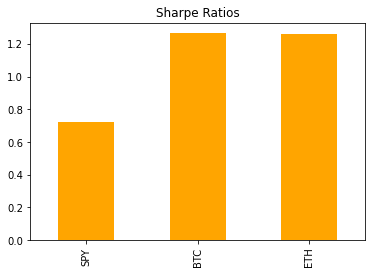

In [80]:
all_sharpe_ratios.plot(kind="bar", title="Sharpe Ratios", color="orange")